# 1. The BlueiceExtendedModel: Rate and shape parameters
In this tutorial, we'll learn about the `BlueiceExtendedModel`, which is based on [blueice](https://github.com/JelleAalbers/blueice) likelihoods and dive into its rate and shape parameters.

## 1.1 Initializing the model

This statistical model has the same basic functionalities to `generate_data` and then `fit` the data. However, the likelihood is a bit more complex than in the previous example. Thus, the definition of the parameters and of the individual likelihood terms are conveniently defined in a YAML configuration file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from alea import BlueiceExtendedModel

In [2]:
# Just some plotting settings
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9

In this tutorial we'll use the example provided in `alea/alea/examples/configs/unbinned_wimp_statistical_model_simple.yaml` and we initialize the model from this file via the `.from_config()` method. You can have a look at the file but **it's not necessary to understand every single entry now**. But here are some comments to help understand the file. You'll find the entries `parameter_definition` and `likelihood_config`:

**parameter_definition**:  
Dictionary of dictionaries containing all parameters defined in the model. The key of each entry is used as `name` of the parameter (for example `wimp_mass`, `livetime`, `wimp_rate_multiplier`, etc.). The entries of each dictionary correspond to respective attributes of the `Parameter` class (for example `nominal_value`, `fittable`, `description`, etc.). To find out the meaning of each of these attributes you can either read about the class in the [documentation](https://alea.readthedocs.io/en/latest/basics/parameters.html), directly look at the `Parameter` class docstring, or execute the following code snippet in the notebook:

```python
from alea import Parameter
Parameter?
```

**likelihood_config**:  
This defines the likelihood created by the class. The most important entry is the `likelihood_terms`, which is a list containing the individual terms that are added to the likelihood. In our case there, there is only one term called `science_run`. The entry `sources` is a list of all the included signal and background sources -- in our case `er` background and `wimp` signal defined in this term of the likelihood. Each source contains information to the location of the template and related parameters.


In [3]:
config_path = "unbinned_wimp_statistical_model_simple.yaml"
model = BlueiceExtendedModel.from_config(config_path)

Computing/loading models on one core: 100%|██████████| 5/5 [00:00<00:00, 646.85it/s]


Again, let's start by looking at which parameters we have defined in the model. Printing the `parameters` object will show us a table with all parameters and their attributes/properties. Especially the last column with the description can be helpful to understand the model:

In [4]:
print(model.parameters)

                      nominal_value  fittable     ptype relative_uncertainty  uncertainty    blueice_anchors fit_limits parameter_interval_bounds  fit_guess                                               description
wimp_mass                      50.0     False      None                 None          NaN               None       None                      None        NaN                                      WIMP mass in GeV/c^2
livetime                        2.0     False  livetime                 None          NaN               None       None                      None        NaN                                         Livetime in years
wimp_rate_multiplier            1.0      True      rate                 None          NaN               None  [0, None]                   [0, 50]        NaN                                                      None
er_rate_multiplier              1.0      True      rate                 True          0.2               None  [0, None]                     

As we already saw in the configuration file, the model consists of a **WIMP signal component** (`wimp_mass`. `wimp_rate_multiplier`) and an **electronic recoil (ER) background** component (`er_rate_multiplier`, `er_band_shift`). In addition there is a parameter called `livetime`, which correspond to the exposure of the data acquisition period.

## 1.2 Generate Data

Before discussing rate and shape parameters, let's have a look at some data generated from the model:

In [5]:
data = model.generate_data()

In [6]:
data.keys()

dict_keys(['science_run', 'ancillary', 'generate_values'])

The data is a dictionary containing data from the `science_run` and the `ancillary` measurements. It also contains the `generate_values`, which are tha values of the parameters used to generate the data. We'll discuss the `ancillary` measurements later and for now focus on the `science_run` data.

In [7]:
data["science_run"]

array([(46.23075713, 3785.8254384 , 0), (13.51097847, 2368.91268987, 0),
       (50.29375555, 4645.70604737, 0), (86.32263227, 5190.61240359, 0),
       (24.28469615, 1831.0807452 , 0), (59.70127754, 3692.42668058, 0),
       (54.74253694, 3316.31124122, 0), (22.04167499, 1392.52028308, 0),
       (95.55604957, 6219.97228189, 0), (10.09021665, 2039.16406492, 0),
       (17.70999996, 1802.39426787, 0), (24.55857586, 2582.12247387, 0),
       (51.07353678, 2703.18731584, 0), ( 7.90927184, 1466.42369337, 0),
       (98.20174817, 6198.74463518, 0), (97.20093081, 5717.29203985, 0),
       (98.84819874, 5359.786693  , 0), (75.88976515, 5663.1405716 , 0),
       (48.26844872, 3199.97540106, 0), (93.60169097, 5889.64926164, 0),
       (39.33268488, 3503.85575919, 0), ( 4.95800634, 1571.65534984, 0),
       ( 4.38727621, 1520.98420431, 0), (45.18103849, 4335.12827043, 0),
       ( 6.43852418, 1698.60128642, 0), (46.95441406, 3298.14744001, 0),
       (71.80828928, 4034.97551652, 0), (16.0793255

We see that the data has entries `cs1`, `cs2`, and `source`. S1 and S2 are the prompt scintillation and delayed signal from drifted electrons, respectively. The "c" in front denotes that those are corrected for detector effects. The key `source` refers to the origin of each event. It is the index of the source name list, which we can look up with the `get_source_name_list` method:

In [8]:
source_name_list = model.get_source_name_list(likelihood_name="science_run")
source_name_list

['er', 'wimp']

Let's have a look at the toy data:

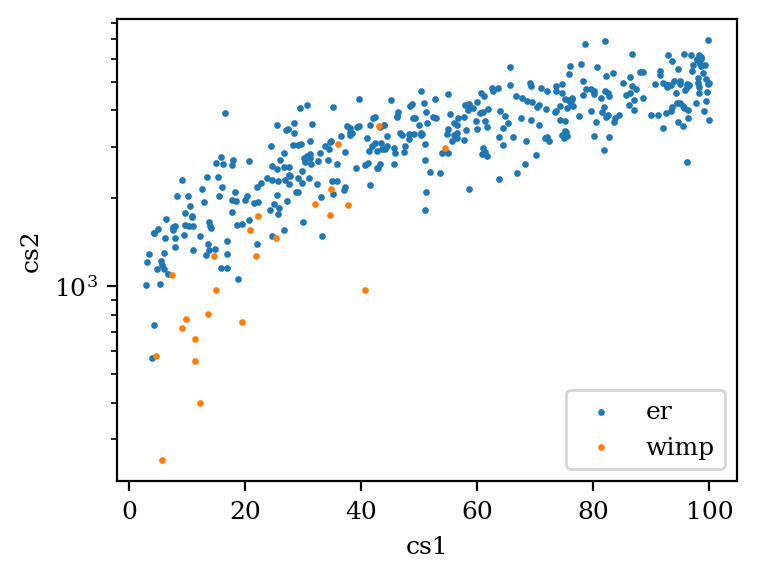

In [9]:
for i, source_name in enumerate(source_name_list):
    mask = data["science_run"]["source"] == i
    plt.scatter(
        data["science_run"]["cs1"][mask], data["science_run"]["cs2"][mask], label=source_name, s=2
    )
plt.xlabel("cs1")
plt.ylabel("cs2")
plt.semilogy()
plt.legend(loc="lower right")

Most WIMP events have lower values of `cs1` and `cs2` compared to the ER events. We can use this to discriminate WIMP signal events from ER background events.

## 1.3 Rate parameters and shape parameters

Blueice distinguished between *rate parameters*, which only scale the expectation value of the respective component, and *shape parameters*, which also change the shape of the component. The only shape parameter used here is the `er_band_shift`, which shifts the ER band in the two dimensional parameter space. To illustrate this, let's look at some toy data:

The rate parameters simply linearly scale the expectation values of each component of the model. Their nominal values are 1.0, which gives the following expectation values for the defined livetime:

In [10]:
model.get_expectation_values()

{'er': 400.0, 'wimp': 20.0}

We can verify that this is roughly what we observed in the data:

In [11]:
for i, source_name in enumerate(source_name_list):
    mask = data["science_run"]["source"] == i
    print(f"Source {source_name} has {np.sum(mask)} events.")

Source er has 400 events.
Source wimp has 24 events.


If we choose a `wimp_rate_multiplier` of 10 we should thus see a 10-fold increase of the expected number of WIMP events:

In [12]:
model.get_expectation_values(wimp_rate_multiplier=10.0)

{'er': 400.0, 'wimp': 200.0}

In [13]:
wimp_rich_data = model.generate_data(wimp_rate_multiplier=10.0)
for i, source_name in enumerate(source_name_list):
    mask = wimp_rich_data["science_run"]["source"] == i
    print(f"Source {source_name} has {np.sum(mask)} events.")

Source er has 393 events.
Source wimp has 198 events.


Now let's see what the shape parameters do. We generate a toy dataset with the nominal and the two extreme values of the `er_band_shift` parameter and see what this does to the data:

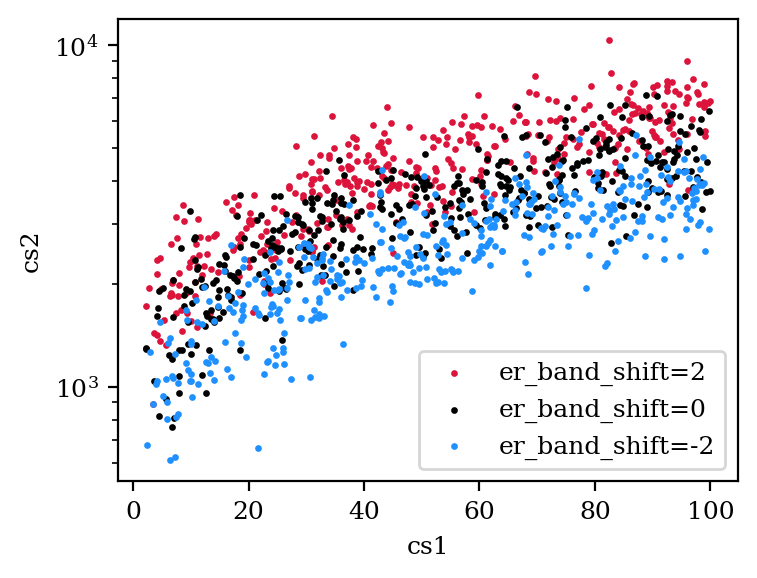

In [14]:
for er_band_shift, c in zip([2, 0, -2], ["crimson", "k", "dodgerblue"]):
    data = model.generate_data(er_band_shift=er_band_shift)
    mask = data["science_run"]["source"] == source_name_list.index("er")
    plt.scatter(
        data["science_run"]["cs1"][mask],
        data["science_run"]["cs2"][mask],
        label=f"er_band_shift={er_band_shift}",
        c=c,
        s=2,
    )
plt.xlabel("cs1")
plt.ylabel("cs2")
plt.semilogy()
plt.legend(loc="lower right")

As you can see, the parameter `er_band_shift` moves the ER band up and down in log(cs2). Note that you can choose any value between the highest and lowest `blueice_anchor` for this parameter, blueice will interpolate the er tamplate for you:

In [15]:
model.parameters.er_band_shift.blueice_anchors

[-2, -1, 0, 1, 2]

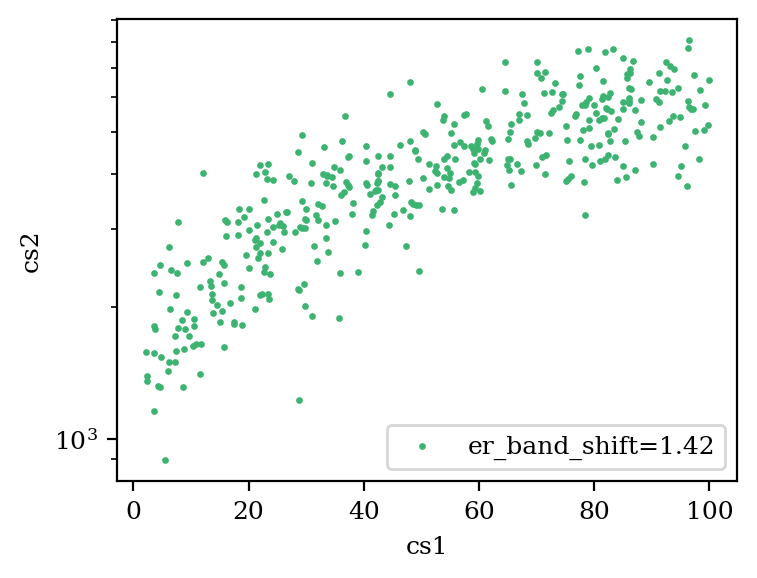

In [16]:
er_band_shift = 1.42
data = model.generate_data(er_band_shift=er_band_shift)
mask = data["science_run"]["source"] == source_name_list.index("er")
plt.scatter(
    data["science_run"]["cs1"][mask],
    data["science_run"]["cs2"][mask],
    label=f"er_band_shift={er_band_shift}",
    c="mediumseagreen",
    s=2,
)
plt.xlabel("cs1")
plt.ylabel("cs2")
plt.semilogy()
plt.legend(loc="lower right")